In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import requests

In [2]:
df = pd.read_csv("mock_data.csv")

In [3]:
# generates a list of species name grouped by col_name
def gen_sets_by_col(df, col_name):
    classes = df[col_name].unique()
    all_set = []
    for c in classes:
        s = list(df[df[col_name] == c]["Species"])
        all_set.extend(s)
    return all_set

# MOCK
# def findDegrees(source, target):
#     idx = np.random.randint(3)
#     arr = np.zeros(3)
#     val = np.random.randint(10)
#     arr[idx] = val
#     return arr

# TODO: what if the page doesn't exists?
def findDegrees(source, target):
    payload = {"source": source, "target": target}
    headers = {'Accept': 'application/json, text/plain, */*', 'Content-Type': 'application/json;charset=UTF-8'}
    url = 'https://api.sixdegreesofwikipedia.com/paths'
    response = requests.post(url, data=json.dumps(payload), headers=headers)
    number_of_degrees = len(response.json()['paths'][0]) - 1
    number_of_paths = len(response.json()['paths'])

    occurrences = [0, 0, 0]

    if number_of_degrees == 1:
        occurrences[0] = number_of_paths
    elif number_of_degrees == 2:
        occurrences[1] = number_of_paths
    else:
        occurrences[2] = number_of_paths

    return occurrences

# calculates the similarity
def sim(source, target):
    w = np.array([4,2,1])
    avg_link = (findDegrees(source, target) + findDegrees(target, source)) / 2
    return np.sum(w * avg_link)

# generate the simularity matrix
# Note that the matrix is symmetric because sim(x,y) == sim(y,x)
def gen_matrix(lst):
    n = len(lst)
    arr = np.zeros((n,n))
    for i in range(n):
        for j in range(i + 1):
            if (i == j):
                arr[i][i] = sim(lst[i], lst[i])
            else:
                t = sim(lst[i], lst[j])
                arr[i][j] = t
                arr[j][i] = t
    return arr

# generates a meatmap from the data frame df grouped by col_name
def gen_heatmap(df,col_name):
    lst = gen_sets_by_col(df, col_name)
    sim_mat = gen_matrix(lst)
    ax = sns.heatmap(sim_mat, cbar_kws={'label': 'Similarity value'})
    plt.xlabel("index of animal") 
    plt.ylabel("index of animal")
    plt.title(f"Similarities between animals by {col_name}")
    plt.show() 

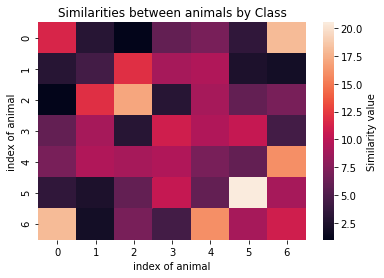

In [4]:
gen_heatmap(df, "Class")